In [1]:
using DrWatson
@quickactivate "FenrirForNeuro"
using CairoMakie
using CSV, DataFrames
using Printf
using Statistics, LinearAlgebra
using FenrirForNeuro, ModelingToolkit, OrdinaryDiffEq
using FileIO
using StatsBase

Axis = CairoMakie.Axis

Makie.Axis

In [2]:
# helpers
function import_csvs(path, fnames, header=nothing)
    dfs = []
    for fname in fnames
        fpath = joinpath(path, fname)
        df = CSV.read(fpath, DataFrame, header=false)
        if header != nothing
            rename!(df, header)
        end
        push!(dfs, df)
    end
    return dfs
end

get_last_rows(trajectories) = vcat([DataFrame(t[end, :]) for t in trajectories]...)


function where_converged(trajectories, threshold=5e-2)
    last_rows = get_last_rows(trajectories)
    pRMSEs = map(x -> rel_pRMSE(x, pvalues(θ)), eachrow(Array(last_rows[!, pkeys(θ)])))
    return pRMSEs .< 5e-2
end


l2 = get_l2_loss()

pkeys(θ) = map(θᵢ -> Symbol(θᵢ[1]), θ)
pvalues(θ) = map(θᵢ -> θᵢ[2], θ)

pvalues (generic function with 1 method)

In [3]:
function find_APpeaks(t, u)
    m = 20
    diff_u = diff([mean(u[i:i+m]) for i in 1:m:length(u)-m])
    u_idxs = collect(1:m:length(u)-m)[2:end-1]
    peak_idxs = u_idxs[(diff_u[1:end-1].>1).&(diff_u[2:end].<-1)]
    peak_idxs = [(i-m:i+m)[argmax(u[i-m:i+m])] for i in peak_idxs]
    # where_above = findall(u .> -30)
    # part_of_spike = cumsum([(diff(t[where_above]) .> 1)...])
    # peak_idxs = []
    # for n in unique(part_of_spike)
    #     spike_above_for_n = where_above[findall(part_of_spike .== n)]
    #     max_idx = spike_above_for_n[argmax(u[spike_above_for_n])]
    #     push!(peak_idxs, max_idx)
    # end
    return peak_idxs
end

function find_APtroughs(t, u)
    peak_idxs = find_APpeaks(t, u)
    trough_idxs = []
    idxs = [peak_idxs..., length(u)]
    for (i1, i2) in zip(idxs[1:end-1], idxs[2:end])
        u_slice = u[i1:i2]
        min_idx = collect(i1:i2)[argmin(u_slice)]
        push!(trough_idxs, min_idx)
    end
    return trough_idxs
end

function NumAPs(t, u)
    at_peaks = find_APpeaks(t, u)
    if length(at_peaks) > 0
        return length(at_peaks)
    else
        return 0
    end
end

function APheight(t, u)
    at_peaks = find_APpeaks(t, u)
    if length(at_peaks) > 0
        return mean(u[at_peaks])
    else
        return NaN
    end
end

function APtrough(t, u)
    at_troughs = find_APtroughs(t, u)
    if length(at_troughs) > 0
        return mean(u[at_troughs])
    else
        return NaN
    end
end

function MeanISI(t, u)
    at_peaks = find_APpeaks(t, u)
    if length(at_peaks) > 1
        return mean(diff(t[at_peaks]))
    else
        return NaN
    end
end

function APamp(t, u)
    peaks = find_APpeaks(t, u)
    troughs = find_APtroughs(t, u)
    if length(peaks) > 0
        return mean(u[peaks] - u[troughs])
    else
        return NaN
    end
end

function V_rest(t, u)
    where_in_T = findall([(10 - 1 .< t .< 10)...])
    return mean(u[where_in_T])
end

function APlatency(t, u)
    t_onset = 10
    peak_idxs = find_APpeaks(t, u)
    if length(peak_idxs) > 0
        return t[peak_idxs[1]] - t_onset
    else
        return NaN
    end
end


function get_features(t, u)
    return [
        NumAPs(t, u),
        APlatency(t, u),
        APheight(t, u),
        APtrough(t, u),
        MeanISI(t, u),
        APamp(t, u),
        V_rest(t, u),
    ]
end

get_features (generic function with 1 method)

In [4]:
HALF_WIDTH = ((6.75 - 0.25) / 2) # inches
FULL_WIDTH = 6.75 # inches
HEIGHT = 0.7 * HALF_WIDTH # inches

PT_PER_INCH = 72
HALF_WIDTH *= PT_PER_INCH
FULL_WIDTH *= PT_PER_INCH
HEIGHT *= PT_PER_INCH

RESULTS_PATH = "../../results/"
FIGURES_PATH = "../../figures/"

PLOT_DEFAULTS = (titlesize=7, xlabelsize=7, ylabelsize=7, xticklabelsize=7, yticklabelsize=7, xticksize=2, yticksize=2)

(titlesize = 7, xlabelsize = 7, ylabelsize = 7, xticklabelsize = 7, yticklabelsize = 7, xticksize = 2, yticksize = 2)

In [5]:
@parameters gNa gK gleak Eleak VT gM gL τ_max
# 6pA
θ = [
    gNa => 25,
    gK => 7,
    gleak => 0.05,
    VT => -60,
    gM => 0.1,
    gL => 0.01,
]

prob_prior, prob =
    get_SinglecompartmentHH(θ; Sys=ReducedPospischilHHSystem, name=:Pospischil)

proj = [1 0 0 0 0 0 0]
observation = generate_data(prob, proj, 1e-2, 1e-2)

(t = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  99.91, 99.92, 99.93, 99.94, 99.95, 99.96, 99.97, 99.98, 99.99, 100.0], u = [[-70.0045673520932], [-69.97543093526336], [-70.01298212102], [-70.07822720802453], [-69.96493001583278], [-69.98975151179803], [-70.0268249839123], [-69.95935294622974], [-69.93773564241376], [-70.00284120125413]  …  [-76.4431478598976], [-76.73457215433551], [-76.66221660509719], [-76.69299154712502], [-76.76320920522097], [-76.71710373199393], [-76.39997466758736], [-76.68778651849664], [-76.51464390351529], [-76.58666696413695]])

In [6]:
BASE_PATH = RESULTS_PATH * "hh/6p/red_pospischil/"

tempering_schedule = reverse([10.0^x for x in 0:20])
sol_obs = simulate(remake(prob, p=pvalues(θ)), 1e-2)
sol_obs = observation[1], vcat(observation[2]...)
fts_obs = get_features(sol_obs...)

# # rk
rk_trajectories = import_csvs(BASE_PATH * "rk4/l2", readdir(BASE_PATH * "rk4/l2"), [pkeys(θ)..., :l, :T])
rk_last_rows = get_last_rows(rk_trajectories)
sols_rk = map(x -> simulate(remake(prob, p=x), 1e-2), eachrow(rk_last_rows[!, pkeys(θ)]))
sols_rk = map(x -> (x[1], (x[2]*proj')[:, 1]), sols_rk)
tRMSEs_rk = map(sol -> tRMSE(sol[2], sol_obs[2]), sols_rk)
fts_rk = map(sol -> get_features(sol...), sols_rk)

# OURS
tempered_trajectories = import_csvs(BASE_PATH * "fenrir/tempered_diff", readdir(BASE_PATH * "fenrir/tempered_diff"), [pkeys(θ)..., :κ², :l, :T])
tempered_last_rows = get_last_rows(tempered_trajectories)
sols_tempered = map(x -> simulate(remake(prob, p=x), 1e-2), eachrow(tempered_last_rows[!, pkeys(θ)]))
sols_tempered = map(x -> (x[1], (x[2]*proj')[:, 1]), sols_tempered)
tRMSEs_tempered = map(sol -> tRMSE(sol[2], sol_obs[2]), sols_tempered)
fts_tempered = map(sol -> get_features(sol...), sols_tempered)

100-element Vector{Vector{Float64}}:
 [4.0, 11.75, 46.053103533285665, -75.21966085307983, 20.33666666666667, 121.27276438636551, -71.12573070506826]
 [1.0, 38.89, 34.32345580065643, -73.27211408541517, NaN, 107.5955698860716, -71.04804435486781]
 [1.0, 46.93, 41.49743968905498, -75.86593281944548, NaN, 117.36337250850045, -70.06886780138592]
 [3.0, 12.14, -29.82749541634091, -75.09955147118143, 16.85, 45.27205605484051, -72.03146089422336]
 [2.0, 45.74, -34.47447813499395, -73.6328535848937, 17.369999999999997, 39.15837544989974, -71.42992706289667]
 [5.0, 11.690000000000001, 34.04404324995722, -69.92652039800909, 14.3825, 103.97056364796632, -71.00025406048229]
 [4.0, 11.5, -34.89291565598134, -71.74371439441744, 17.39, 36.85079873843609, -71.20854738094933]
 [5.0, 11.829999999999998, 23.375399043384625, -75.99575113024949, 16.6725, 99.37115017363412, -70.68376218625745]
 [5.0, 11.86, 19.423986143292524, -76.34773507677237, 16.63, 95.7717212200649, -70.52408932259024]
 [7.0, 11.85000

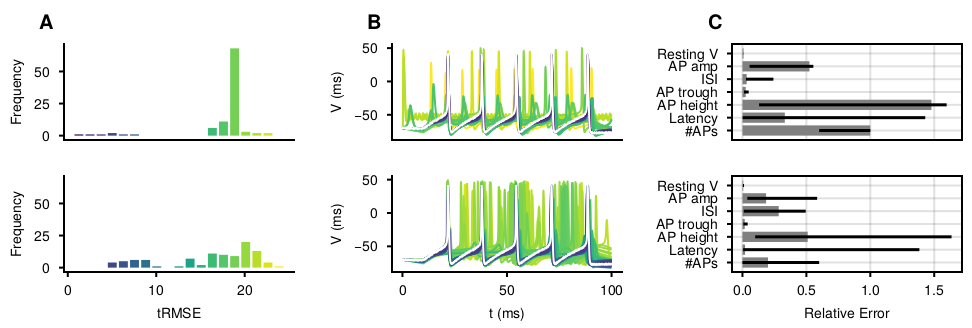

In [7]:
f = Figure(size=(FULL_WIDTH, HEIGHT), figure_padding=5)

fa = f[1, 1] = GridLayout()
fb = f[1, 2] = GridLayout()
fc = f[1, 3] = GridLayout()

ax1 = Axis(fa[1, 1], xlabel="tRMSE", ylabel="Frequency"; PLOT_DEFAULTS...)
ax2 = Axis(fa[2, 1], xlabel="tRMSE", ylabel="Frequency"; PLOT_DEFAULTS...)
ax3 = Axis(fb[1, 1], xlabel="t (ms)", ylabel="V (ms)"; PLOT_DEFAULTS...)
ax4 = Axis(fb[2, 1], xlabel="t (ms)", ylabel="V (ms)"; PLOT_DEFAULTS...)
ax5 = Axis(fc[1, 1], xlabel="Relative Error"; PLOT_DEFAULTS...)
ax6 = Axis(fc[2, 1], xlabel="Relative Error"; PLOT_DEFAULTS...)

max_err = maximum([tRMSEs_tempered..., tRMSEs_rk...])

sort_by(a,b) = a[reverse(sortperm(b))]

h_rk = fit(Histogram, tRMSEs_rk, LinRange(0, max_err, 20))
h_tempered = fit(Histogram, tRMSEs_tempered, LinRange(0, max_err, 20))
get_bin_centers(h) = h.edges[1][1:end-1] + diff(h.edges[1])

barplot!(ax1, get_bin_centers(h_rk), h_rk.weights, color=get_bin_centers(h_rk), colorrange=(0, max_err), colormap=:viridis)
barplot!(ax2, get_bin_centers(h_tempered), h_tempered.weights, color=get_bin_centers(h_tempered), colorrange=(0, max_err), colormap=:viridis)
linkyaxes!(ax1, ax2)

sols_rk = sort_by(sols_rk, tRMSEs_rk)
tRMSEs_rk = sort_by(tRMSEs_rk, tRMSEs_rk)
for (sol, err) in zip(sols_rk, tRMSEs_rk)
    lines!(ax3, sol..., color=err, linewidth=1, colorrange=(0, max_err), colormap=:viridis)
end

sols_tempered = sort_by(sols_tempered, tRMSEs_tempered)
tRMSEs_tempered = sort_by(tRMSEs_tempered, tRMSEs_tempered)
for (sol, err) in zip(sols_tempered, tRMSEs_tempered)
    lines!(ax4, sol..., color=err, linewidth=1, colorrange=(0, max_err), colormap=:viridis)
end

lines!(ax3, sol_obs[1], sol_obs[2], color=:white, linewidth=1)
lines!(ax4, sol_obs[1], sol_obs[2], color=:white, linewidth=1)

for ax in [ax1, ax2, ax3, ax4]
    hidespines!(ax, :t, :r)
    hidedecorations!(ax, grid=true, label=false, ticks=false, ticklabels=false)
end

ft_names = ["#APs", "Latency", "AP height", "AP trough", "ISI", "AP amp", "Resting V"]
ft_rk_err = abs.((hcat(fts_rk...)' .- fts_obs') ./ fts_obs')
ft_tempered_err = abs.((hcat(fts_tempered...)' .- fts_obs') ./ fts_obs')

ft_rk_med_err = (map(x -> median(x[.!isnan.(x)]), eachcol(ft_rk_err)))
ft_rk_q1_err = (map(x -> quantile(x[.!isnan.(x)], 0.25), eachcol(ft_rk_err)))
ft_rk_q3_err = (map(x -> quantile(x[.!isnan.(x)], 0.75), eachcol(ft_rk_err)))
ft_tempered_med_err = (map(x -> median(x[.!isnan.(x)]), eachcol(ft_tempered_err)))
ft_tempered_q1_err = (map(x -> quantile(x[.!isnan.(x)], 0.25), eachcol(ft_tempered_err)))
ft_tempered_q3_err = (map(x -> quantile(x[.!isnan.(x)], 0.75), eachcol(ft_tempered_err)))

barplot!(ax5, 1:length(ft_names), ft_rk_med_err, color=:grey, direction=:x)
errorbars!(ax5, ft_rk_med_err, 1:length(ft_names), ft_rk_med_err - ft_rk_q1_err, ft_rk_q3_err - ft_rk_med_err, color=:black, direction=:x)
# scatter!(ax5, reshape((ft_rk_err), :), reshape(repeat(1:length(ft_names), 100), :) + 0.1 * randn(length(ft_names)*100), color=:black, orientation=:horizontal, markersize=2, alpha=0.3)
barplot!(ax6, 1:length(ft_names), ft_tempered_med_err, color=:grey, direction=:x)
errorbars!(ax6, ft_tempered_med_err, 1:length(ft_names), ft_tempered_med_err - ft_tempered_q1_err, ft_tempered_q3_err - ft_tempered_med_err, color=:black, direction=:x)
# scatter!(ax6, reshape((ft_rk_err), :), reshape(repeat(1:length(ft_names), 100), :) + 0.1 * randn(length(ft_names) * 100), color=:black, orientation=:horizontal, markersize=2, alpha=0.3)


ax5.yticks = (1:length(ft_names), ft_names)
ax6.yticks = (1:length(ft_names), ft_names)
# ax6.xticks = ([-2, -1, 0, 1, 2], ["-200%", "-100%", "0%", "100%", "200%"])
linkxaxes!(ax5, ax6)

hidexdecorations!(ax1)
hidexdecorations!(ax3)
hidexdecorations!(ax5, grid=false)


Label(f.layout[1, 1, TopLeft()], "A", fontsize=10, font=:bold, padding=(0, 5, 5, 0), halign=:right)
Label(f.layout[1, 2, TopLeft()], "B", fontsize=10, font=:bold, padding=(0, 5, 5, 0), halign=:right)
Label(f.layout[1, 3, TopLeft()], "C", fontsize=10, font=:bold, padding=(0, 5, 5, 0), halign=:right)
f

In [8]:
save(joinpath(FIGURES_PATH, "figure6.pdf"), f, overwrite=true)

CairoMakie.Screen{PDF}
